# Set up waterbalance manually<a id="top"></a>

_Developed by Davíd Brakenhoff (Artesia) on July 19, 2019_

This notebook describes how a waterbalance can be set up from scratch.

## Contents
- [Getting started](#1)
- [EAG object](#2)
- [Buckets](#3)
- [Adding timeseries](#4)
- [Simulating the water balance](#5)
- [Simulation results](#6)
- [Visualizing the results](#7)

## [Getting started](#top)<a id="1"></a>

In order to use the `waterbalans` module it needs to be installed. This can be done by cloning the repository from [GitHub](https://github.com/ArtesiaWater/waterbalans). Unzip the file. Open the Anaconda Prompt (e.g. by searching for Anaconda in Windows Start Menu). Navigate to the location you unzipped the Github repository using `cd <path>`. When you reach the right directory type `pip install -e .`. This will install the `waterbalans` module.

If this was successful the following imports should not yield any errors:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import waterbalans as wb

## [EAG object](#top)<a id="2"></a>

The `waterbalans` module contains the Eag object. EAG is an abbreviation used at Waternet which stands for "Ecologisch AandachtsGebied". This is an area with similar characteristics from an ecological point of view. The water balance is calculated for this area to determine the amount of nutrients and other chemicals present in surface water as a result of the different incoming and outgoing fluxes. 

For the Python tool, the EAG is the fundamental object that holds all of the information about this area. This includes areas with different runoff characteristics, but also the timeseries representing the different fluxes.

To create an Eeg provide it with an ID number and a name.

In [2]:
e = wb.Eag(idn=1, name="my_little_eag")

This is still quite useless as there are no runoff areas or fluxes defined within the EAG.

In [3]:
e

<EAG object: my_little_eag>

## [Buckets](#top)<a id="3"></a>

The next step in setting up your EAG is to define what the characteristics are of different areas within your EAG. This is done by adding so-called buckets, which act as hydrologically separate areas that each interact with surface water in their own way.

There are 4 types of buckets representing land area:
- Verhard (for paved areas)
- Onverhard (for unpaved areas)
- Drain (for unpaved areas with drainage)
- MengRiool (for combined sewer overflows)

The last bucket (MengRiool) is a strange one as it does not really work like the other buckets, but more on that in a later notebook.

There is also a bucket that represents surface water:
- Water (for surface water)

Let's add two land buckets: a Verhard (paved) bucket and an Onverhard (unpaved) bucket each with an area of 100 m$^2$. The different bucket types are accessible through `wb.buckets`. Adding a bucket requires a unique ID, a parent EAG object, timeseries you wish to add (which is allowed to be set to None) and most importantly an area in square meters.

In [4]:
b1 = wb.buckets.Verhard(10, e, series=None, area=100.0)
b2 = wb.buckets.Onverhard(20, e, series=None, area=100.0)

Let's take a look at one of the buckets:

In [5]:
b1

<10: Verhard bucket with area 100.0>

The buckets are automatically added to the EAG:

In [6]:
e.buckets

OrderedDict([(10, <10: Verhard bucket with area 100.0>),
             (20, <20: Onverhard bucket with area 100.0>)])

A waterbalance also requires a Water bucket to be added. So let's go ahead and add one with an area of 100 m$^2$.

In [7]:
w = wb.water.Water(30, e, None, area=100.)

This bucket is stored under `e.water`:

In [8]:
e.water

<30: Water bucket with area 100.0>

We have now defined the different zones within our area of interest, 100 m$^2$ of paved area, 100 m$^2$ of unpaved area and 100 m$^2$ of surface water. There is a helpful function to summarize the structure of your EAG:

In [9]:
e.get_modelstructure()

,Name,Area,BucketObj
ID,,,
10,Verhard,100.0,<10: Verhard bucket with area 100.0>
20,Onverhard,100.0,<20: Onverhard bucket with area 100.0>
30,Water,100.0,<30: Water bucket with area 100.0>


## [Timeseries](#top)<a id="4"></a>

The next step is to define the external forcing on our system, i.e. the amount of water coming in and going out. Let's create some series for precipitation and evaporation with units m/day.

In [10]:
index = pd.date_range("2019-01-01", "2019-01-31", freq="D")
neerslag = pd.Series(index=index, data=np.random.random_sample(31)) * 1e-3
neerslag.name = "Neerslag"
verdamping = 0.75 * pd.Series(index=index, data=np.random.random_sample(31)) * 1e-3
verdamping.name = "Verdamping"

Let's see what those random series look like

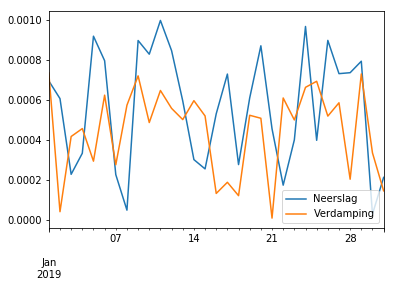

In [11]:
ax = neerslag.plot()
verdamping.plot(ax=ax)
ax.legend(loc="best")

Let's also add a water level series:

In [12]:
peil = pd.Series(index=index, data=np.zeros(31))

The next step is to add these timeseries to our Eag object. This is done with the `e.add_timeseries` method.

In [13]:
e.add_timeseries(neerslag, name="Neerslag")
e.add_timeseries(verdamping, name="Verdamping")
e.add_timeseries(peil, name="Peil")

2019-07-19 10:40:12,125 | add_timeseries - INFO : Adding timeseries 'Neerslag' to EAG manually
2019-07-19 10:40:12,142 | add_timeseries - INFO : Adding timeseries 'Verdamping' to EAG manually
2019-07-19 10:40:12,150 | add_timeseries - INFO : Adding timeseries 'Peil' to EAG manually


Note the information that is printed informing the user that a timeseries was added to the EAG. Once you create an Eag a logger is created that logs information about what is happening as a user adds timeseries to the Eag. These messages can be suppressed or written to a file.

The series added to the Eag are stored in `e.series`.

In [14]:
e.series.head()

,Neerslag,Verdamping,Peil
2019-01-01,0.000695,0.000735,0.0
2019-01-02,0.000606,0.000040,0.0
2019-01-03,0.000227,0.000417,0.0
2019-01-04,0.000333,0.000456,0.0
2019-01-05,0.000919,0.000293,0.0


## [Simulating the water balance](#top)<a id="5"></a>

The next step is to simulate the water balance and see what happens to the water level in our area of interest. Simulation of the waterbalance is done by calling `e.simulate()` The call to simulate requires the model parameters to be passed to the function and optionally the desired start and end time of the simulation. 

The parameters govern the flow through the buckets (i.e. the initial water level in the buckets, the maximum water storage within the buckets, the runoff coefficients, etc.). At creation default values are set for the parameters of each bucket. 

The complete set of parameters in the model can be obtained by calling `e.get_parameter_df()`. This returns a DataFrame containing all of the model parameters and can be used to simulate the model. Let's adjust the `hTargetMax` parameter to allow some storage in the system.

In [15]:
params = e.get_parameter_df()
params.loc[17, "Waarde"] = 0.05
params

,Bakje,BakjeID,ParamCode,Laagvolgorde,Waarde
0,Verhard,10,hMax,1,0.002
1,Verhard,10,hMax,2,1
2,Verhard,10,hInit,1,0.5
3,Verhard,10,EFacMin,1,1
4,Verhard,10,EFacMax,1,1
5,Verhard,10,RFacIn,2,0.1
6,Verhard,10,RFacOut,2,0.1
7,Verhard,10,por,2,0.2
8,Onverhard,20,hMax,1,0.5
9,Onverhard,20,hInit,1,0.5


Simulate the model

In [16]:
e.simulate(params)

2019-07-19 10:40:12,259 | simulate - INFO : Simulating: my_little_eag...
2019-07-19 10:40:12,263 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 10
2019-07-19 10:40:12,276 | simulate - WARNING : Warning: {'Qkwel'} not in series. Assumed equal to 0!
2019-07-19 10:40:12,292 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 20
2019-07-19 10:40:12,303 | simulate - WARNING : Warning: {'Qkwel'} not in series. Assumed equal to 0!
2019-07-19 10:40:12,311 | simulate - INFO : Simulating the waterbalance for bucket: Water 30
2019-07-19 10:40:12,369 | simulate - INFO : Simulation succesfully completed in 0.1s.


Note the Information and warnings that are printed to the console. The simulation warns the user if default values are selected for certain parameters. In this case Qkwel (seepage) which usually is defined as a timeseries in a water balance is assumed to be 0.

## [Simulation results](#top)<a id="6"></a>

The simulation results can viewed per bucket, but also aggregated for the whole area of interest as a whole. In each bucket the fluxes coming in and going out of that bucket are stored under the fluxes attribute.

For the paved bucket:

In [17]:
b1.fluxes.head()

,q_no,q_ui,q_s,q_oa
2019-01-01,-0.000040,-0.010000,0.0,0.0
2019-01-02,0.000566,-0.009000,0.0,0.0
2019-01-03,-0.000189,-0.008100,0.0,0.0
2019-01-04,-0.000124,-0.007290,0.0,0.0
2019-01-05,0.000626,-0.006561,0.0,0.0


And in the water bucket:

In [18]:
e.water.fluxes.head()

,q_ui_10,q_oa_10,q_ui_20,q_oa_20,Neerslag,Verdamping,q_in,q_out
2019-01-01,1.0000,-0.0,0.100000,-0.0,0.069488,-0.029389,0.0,0.0
2019-01-02,0.9000,-0.0,0.097920,-0.0,0.060632,-0.001594,0.0,0.0
2019-01-03,0.8100,-0.0,0.097095,-0.0,0.022709,-0.016661,0.0,0.0
2019-01-04,0.7290,-0.0,0.094774,-0.0,0.033262,-0.018246,0.0,0.0
2019-01-05,0.6561,-0.0,0.092632,-0.0,0.091889,-0.011718,0.0,0.0


The column names specify the type of flux, and in the case of the water bucket, the bucket ID is appended to the name to identify which flux belongs to which bucket. The codes are explained below:
- Neerslag: precipitation
- Verdamping: evaporation
- q_ui: intrek/uitspoeling (subsurface runoff, and the reverse process, water infiltrating in dry periods).
- q_oa: oppervlakkige afstroming, surface runoff
- q_s: seepage
- q_in: flux in from external source to close the balance
- q_out: flux outwards to close the balance

Aggregating the fluxes to get the total amount per flux type is done by calling `e.aggregate_fluxes()`. This also translates the more obscure codes above into more clear descriptions of the different fluxes.

In [19]:
e.aggregate_fluxes().head()

,neerslag,verdamping,kwel,wegzijging,verhard,berekende inlaat,berekende uitlaat,drain,uitspoeling,intrek,afstroming,q_cso
2019-01-01,0.069488,-0.029389,NaN,NaN,0.0,0.0,0.0,0.0,1.100000,0.0,0.0,0.0
2019-01-02,0.060632,-0.001594,NaN,NaN,0.0,0.0,0.0,0.0,0.997920,0.0,0.0,0.0
2019-01-03,0.022709,-0.016661,NaN,NaN,0.0,0.0,0.0,0.0,0.907095,0.0,0.0,0.0
2019-01-04,0.033262,-0.018246,NaN,NaN,0.0,0.0,0.0,0.0,0.823774,0.0,0.0,0.0
2019-01-05,0.091889,-0.011718,NaN,NaN,0.0,0.0,0.0,0.0,0.748732,0.0,0.0,0.0


The storage and water levels of the buckets can be obtained through the `storage` and `level` attributes. You can try this yourself.

## [Visualizing the results](#top)<a id="7"></a>

A bunch of default plots have been defined in the `e.plot` module. Options include:
- `aggregated` : bar chart of aggregated fluxes (by default per month)
- `bucket` :  fluxes per bucket (by default per month)
- `series` : all the timeseries added to the EAG in a separate plot
- `water_level` : the water level in surface water bucket

Examples of these visualizations are shown below:

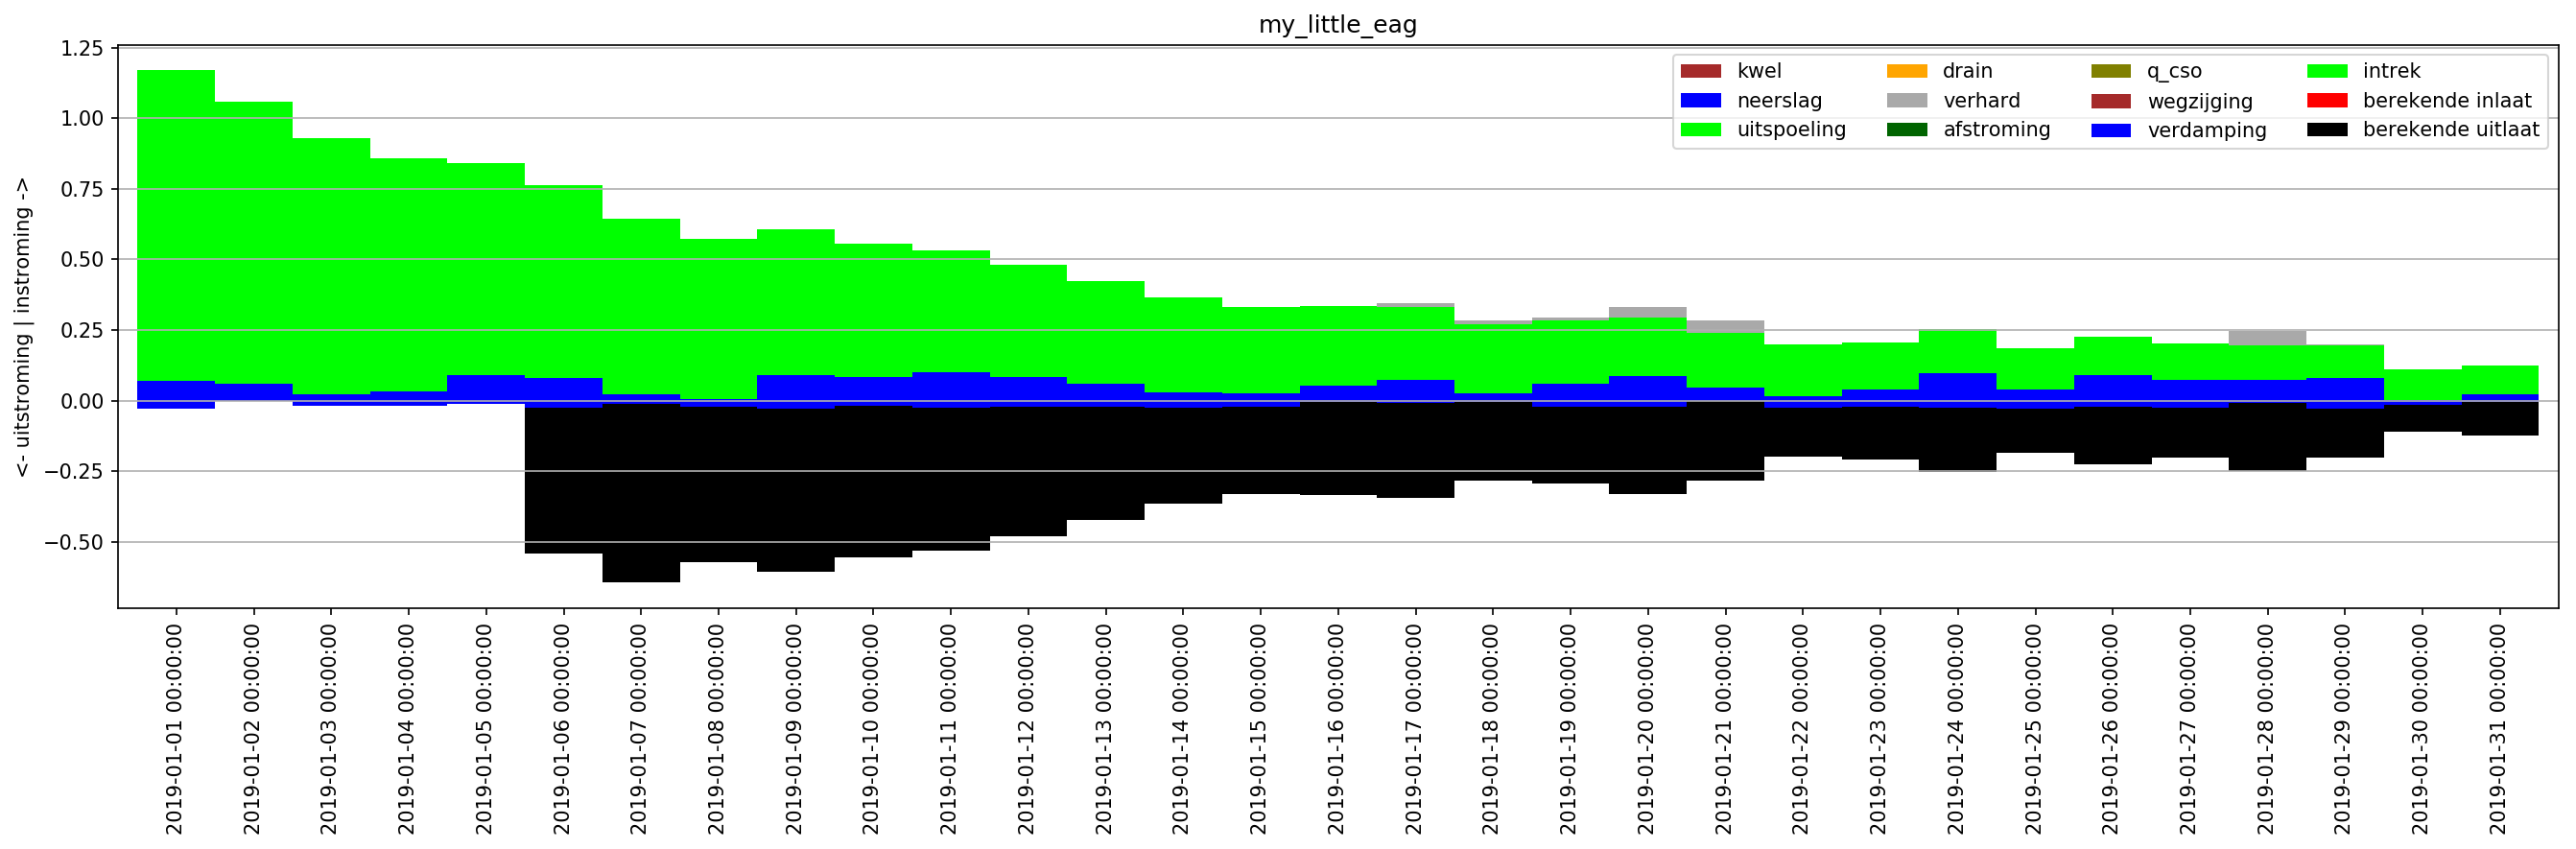

In [20]:
e.plot.aggregated(freq="D")

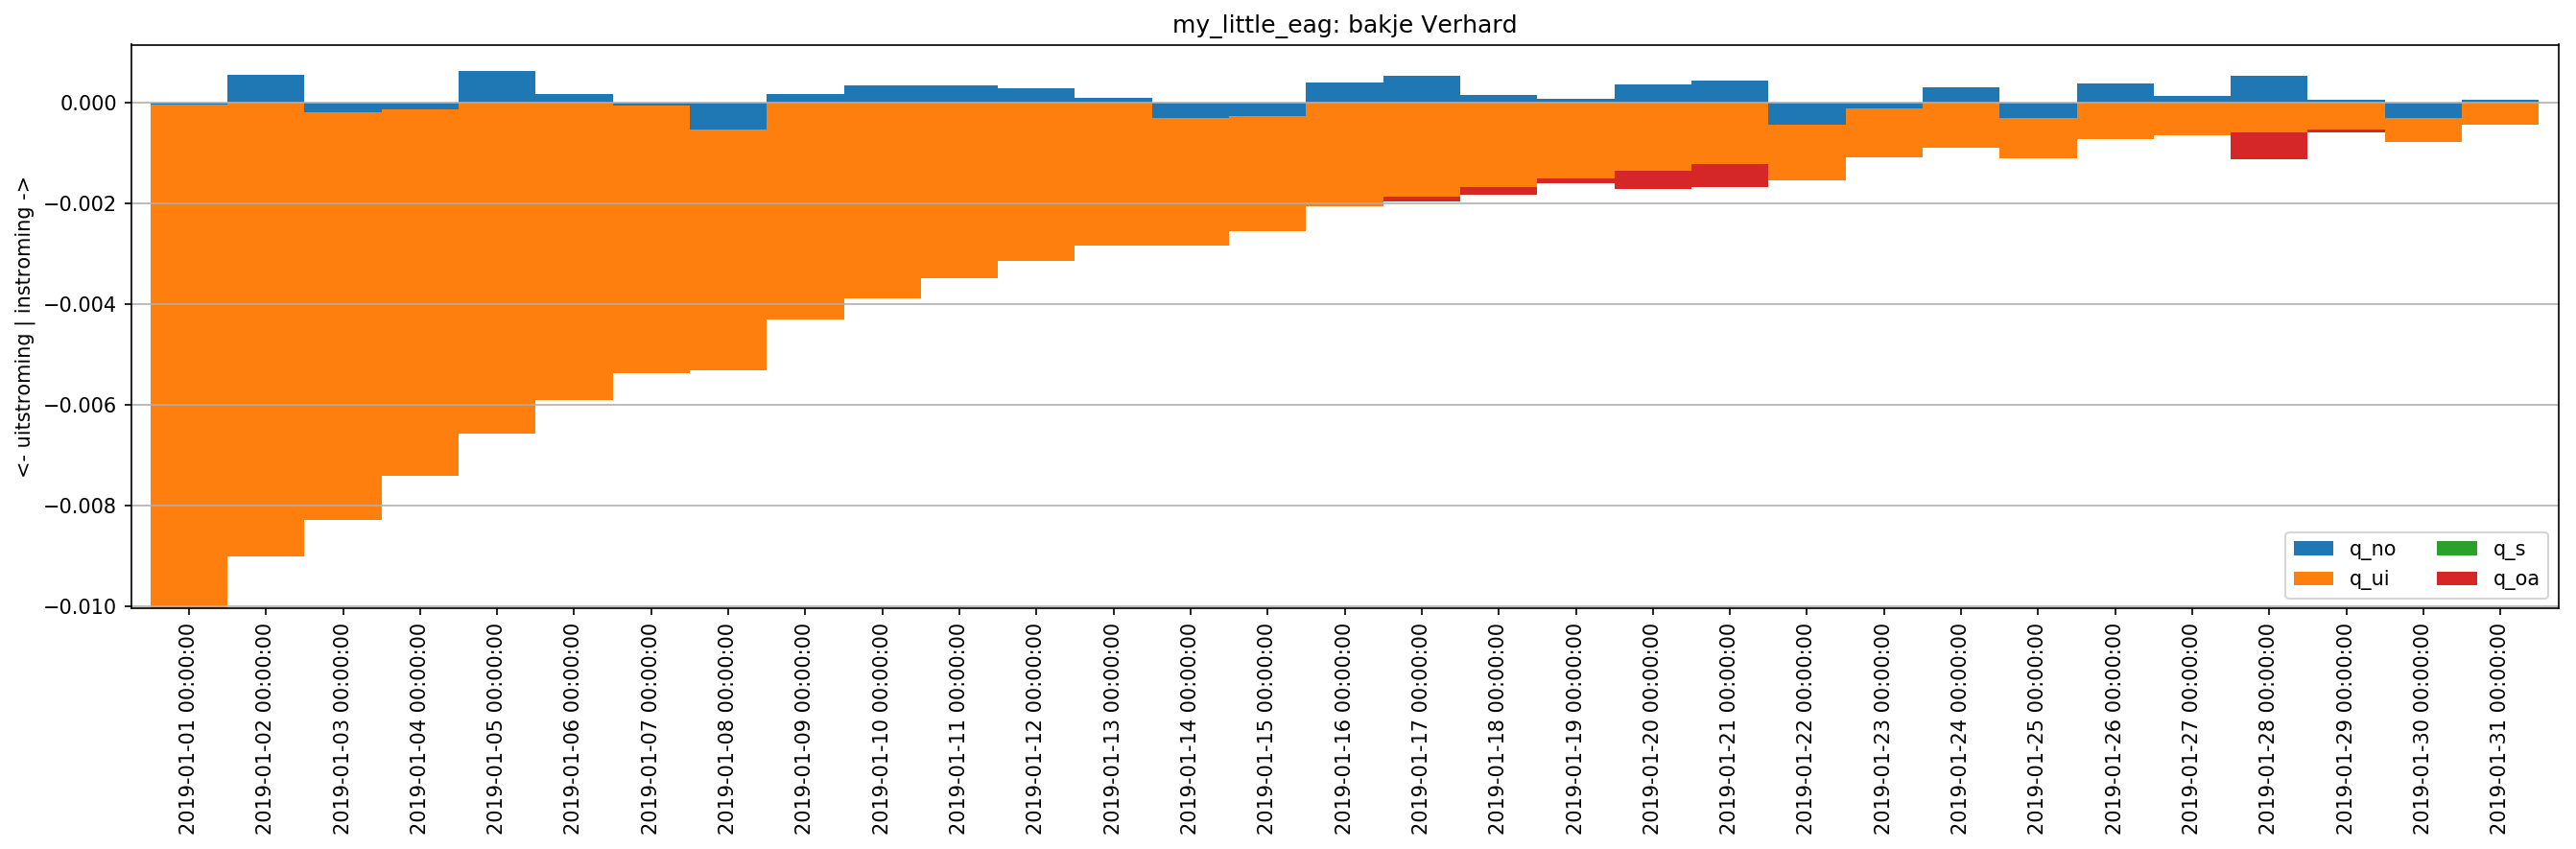

In [24]:
e.plot.bucket(10, freq="D")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000250AD271198>,
      dtype=object)

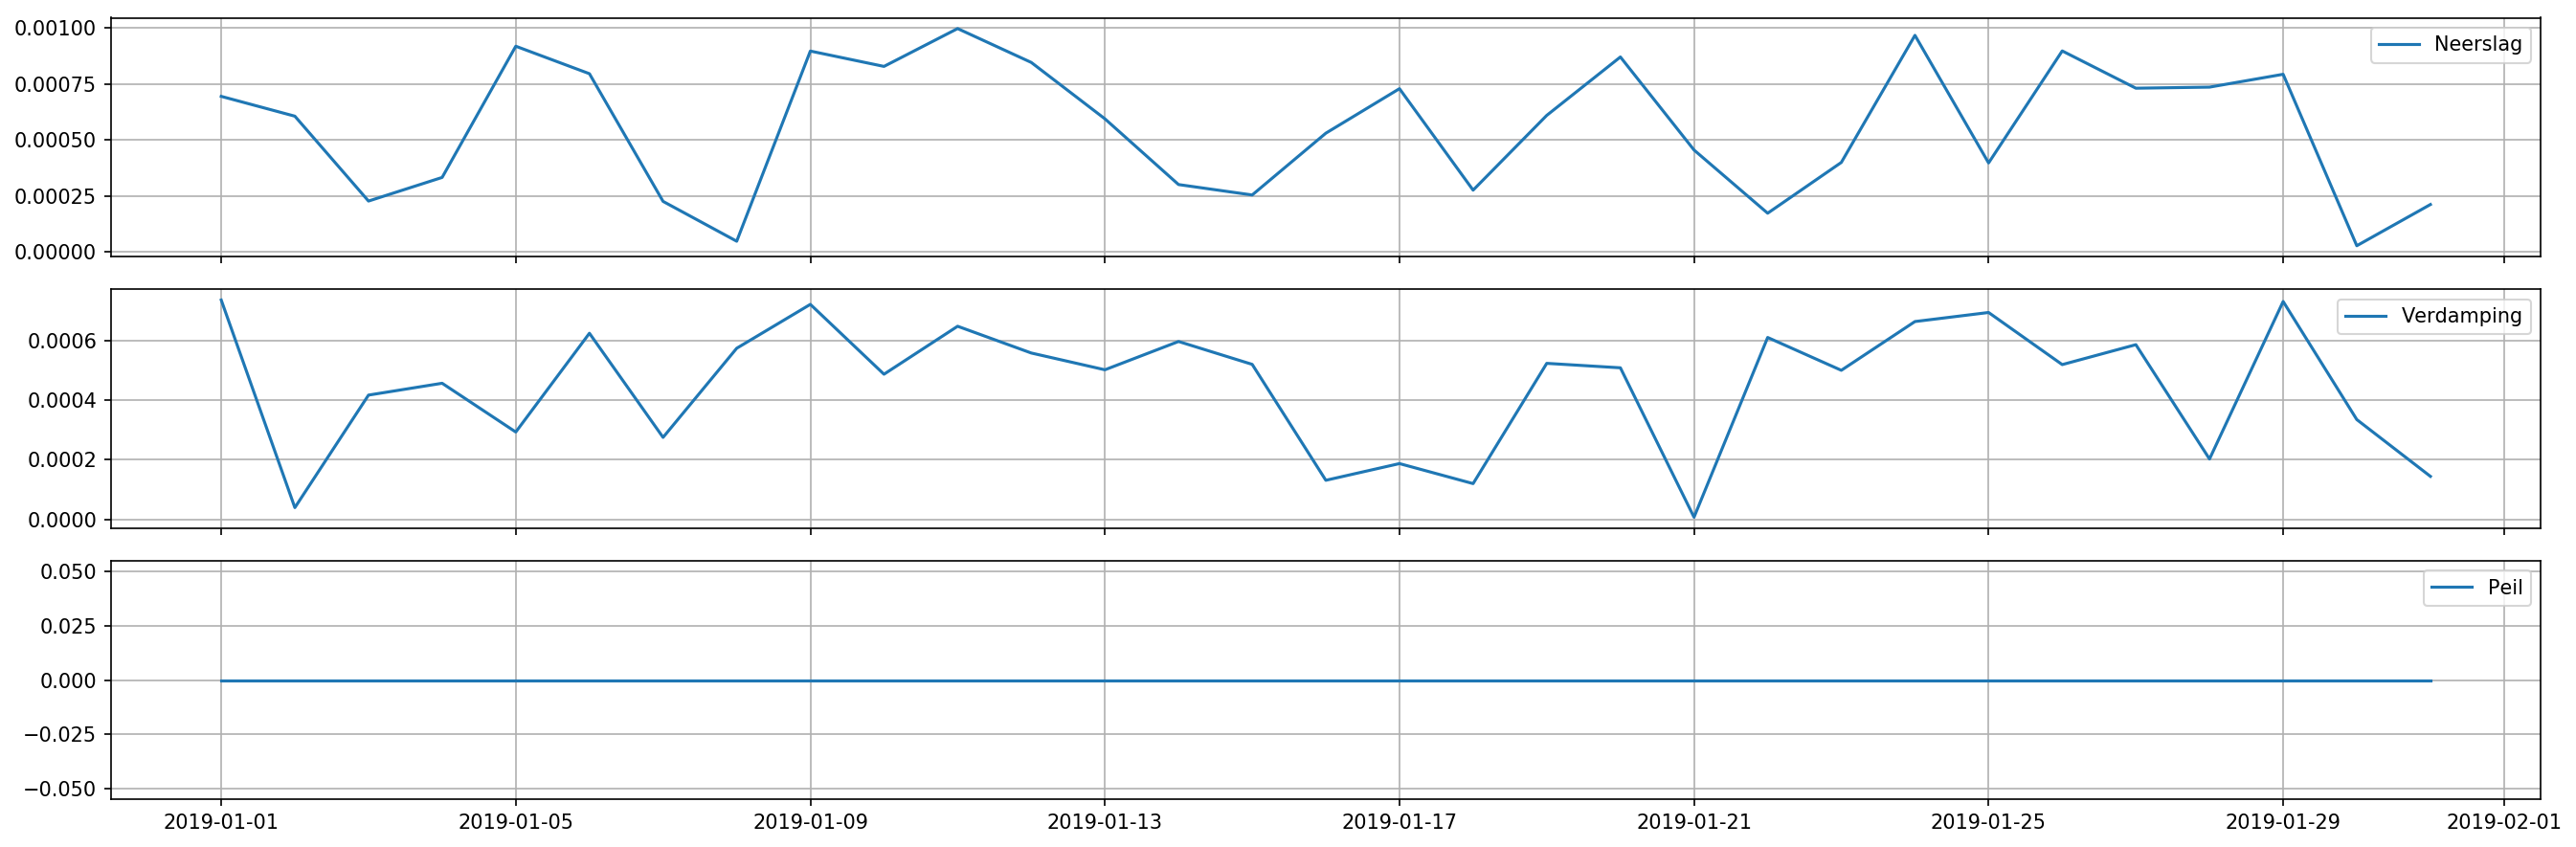

In [22]:
e.plot.series()

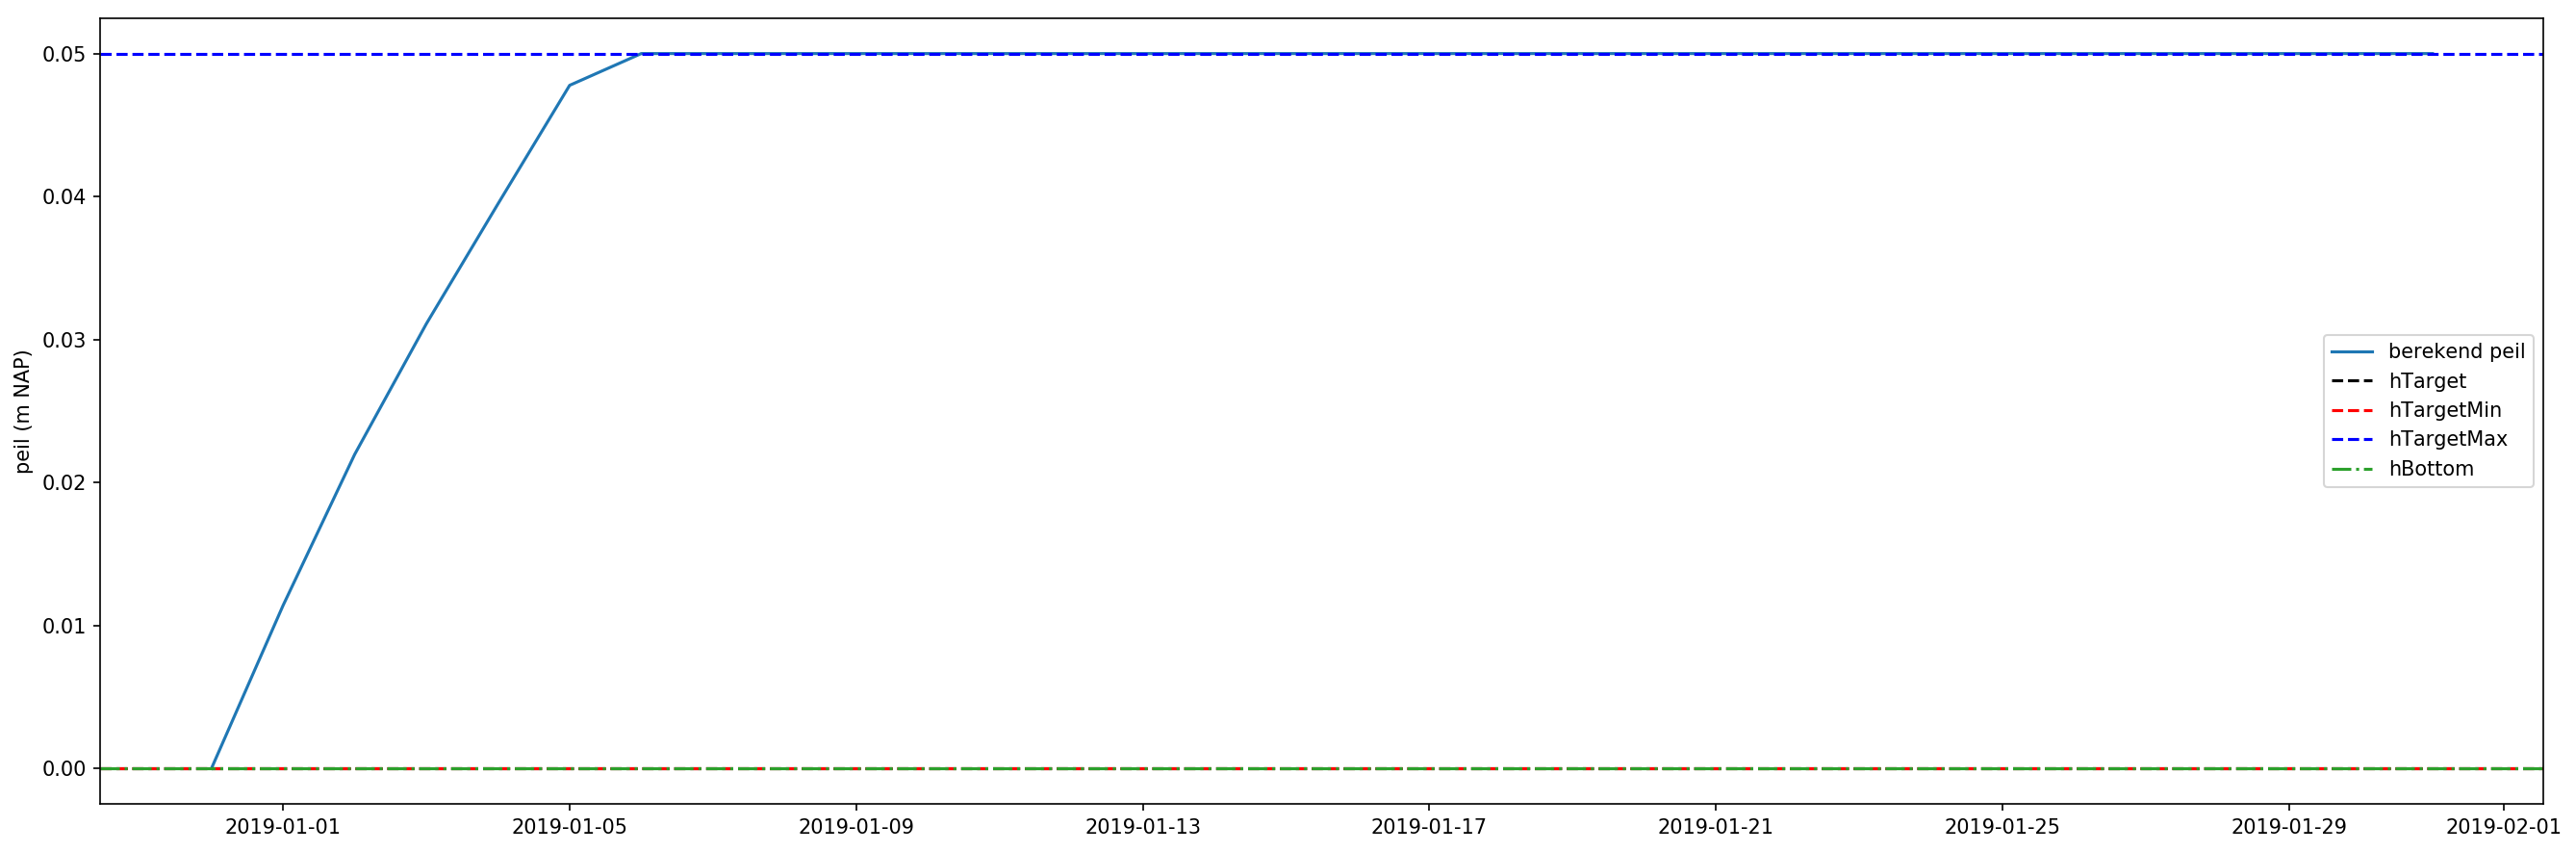

In [23]:
e.plot.water_level()